In [2]:
import os

# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as krl
from tensorflow.keras import models as krm

#Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import sys

# Google file system
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


## Recoger los datos de entrenamiento, validación y test

In [3]:
BASE_DIR = '/gdrive/MyDrive/RedesNeuronales'
ATT_FILE = f'{BASE_DIR}/data/FootballPlayerPreparedCleanAttributes.csv'
LABEL_FILE = f'{BASE_DIR}/data/FootballPlayerOneHotEncodedClasses.csv'

TRAIN_RATE = 0.8
VAL_RATE = 0.1
TEST_RATE = 0.1

attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)

n_instances = attributes.shape[0]
n_train = int(n_instances*TRAIN_RATE)
n_val = int(n_instances*VAL_RATE)
n_test = n_instances - (n_train + n_val)

x_train = attributes.values[:n_train]
y_train = label.values[:n_train]

x_val = attributes.values[n_train:n_train+n_val]
y_val = label.values[n_train:n_train+n_val]

x_test = attributes.values[n_train+n_val:]
y_test = label.values[n_train+n_val:]

print ('x_train:', x_train.shape)
print ('y_train:', y_train.shape)

print ('x_val:', x_val.shape)
print ('y_val:', y_val.shape)

print ('x_test:', x_test.shape)
print ('y_test:', y_test.shape)

print(f'checksum: {x_train.shape[0]+x_val.shape[0]+x_test.shape[0]}={n_instances}')

x_train: (12897, 17)
y_train: (12897, 4)
x_val: (1612, 17)
y_val: (1612, 4)
x_test: (1613, 17)
y_test: (1613, 4)
checksum: 16122=16122


## Diseñar el workflow para la prueba de modelos

In [4]:
INPUTS = x_train.shape[1]
OUTPUTS = y_train.shape[1]

class Experiment:
    # Accuracy must be first
    default_metrics = ['categorical_accuracy', 'AUC']

    default_label_name_association = {
        'categorical_accuracy': 'Accuracy',
        'auc': 'Area under ROC curve',
        'loss': 'Categorical cross-entropy (loss)'
    }

    def __init__(self, e_id, model=None, optimizer='SGD', epochs=500, metrics=None,
                 loss='categorical_crossentropy', label_name_association=None, verbose=1, human_error=0.0, path='models', batch_size=None):
        self.e_id = e_id
        self.metrics = self.default_metrics if not metrics else metrics
        self.label_name_association = self.default_label_name_association if not label_name_association else label_name_association
        self.epochs = epochs
        self.model = model
        self.verbose = verbose
        self.human_error = human_error
        self.batch_size = batch_size
        if model:
            self.model.add(krl.Dense(units=OUTPUTS, activation='softmax'))
            self.model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=self.metrics
            )
        self.path = f'{BASE_DIR}/{path}/{self.e_id}'

    def run(self):
        history = self.model.fit(x_train, y_train, epochs=self.epochs, verbose=self.verbose, validation_data=(x_val, y_val), batch_size=self.batch_size)
        clear_output(wait=True)
        self.model.summary()
        self.save()
        self.plot_history(history)
        self.print_metrics()


    def plot_history(self, history):
        fig = plt.figure(figsize=(22, 10), constrained_layout=True)
        rows = 2
        cols = int(np.ceil(len(history.history) / (2 * rows)))
        gs = fig.add_gridspec(rows, cols)
        fig.suptitle('Resultados')

        for i, key in enumerate(self.label_name_association.keys()):
            label = self.label_name_association[key]
            r, c = i // cols, i % cols
            f_ax = fig.add_subplot(gs[r, c])
            f_ax.plot(history.history[key], label=label)
            f_ax.plot(history.history[f'val_{key}'], label=f'Validation {label.lower()}')
            f_ax.set_ylabel('')
            f_ax.set_xlabel('Epoch')
            f_ax.set_ylim(bottom=0, top=1)
            f_ax.legend(loc='upper left')
            f_ax.set_title(label)
        fig.show()
        plt.savefig(f'{self.path}/tfmodel', dpi=300)


    def print_metrics(self, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val):
        train_res = self.model.evaluate(x_train, y_train)
        val_res = self.model.evaluate(x_val, y_val)
        loss, accuracy = train_res[:2]
        val_loss, val_accuracy = val_res[:2]
        bias = (1 - accuracy - self.human_error)
        variance = (1 - val_accuracy) - bias
        prediction_error = (bias**2) + variance + self.human_error
        with open(f'{self.path}/metrics.txt', 'w') as out:
            for f in (sys.stdout, out):
                print(f'Human error: {self.human_error * 100:.2f}%', file=f)
                print(f'Bias=(1-train_accuracy) - human error: {bias * 100:.2f}%', file=f)
                print(f'Variance=(1-val_accuracy) - bias: {variance * 100:.2f}%', file=f)
                print(f'Prediction Error = Bias² + Variance + Human error:  {prediction_error:.2f}', file=f)
                # Print other additional metrics
                i = 1
                for other_metric, other_val_metric in zip(train_res[2:], val_res[2:]):
                    metric_name = self.label_name_association[self.metrics[i].lower()]
                    print(f'{metric_name} Train: {other_metric*100:.2f}%', file=f)
                    print(f'{metric_name} Validation: {other_val_metric * 100:.2f}%', file=f)
                    i += 1


    def save(self):
        self.model.save(f'{self.path}/tfmodel')


    def load(self):
        self.model = self.model.load_model(f'{self.path}/tfmodel')

## Empezar el bucle de prueba de modelos

### Intento 1.1 de reducir el bias

Actualmente se tiene que buscar un modelo que reduzca el bias. Como es lo preferible, en primer lugar se probará con un modelo sencillo, sin capas ocultas.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 72        
                                                                 
Total params: 72
Trainable params: 72
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /gdrive/MyDrive/RedesNeuronales/models/bias_decrease_1_1/tfmodel/assets
51/51 [==============================] - 0s 2ms/step - loss: 0.6831 - categorical_accuracy: 0.7103 - auc: 0.9159
Human error: 0.00%
Bias=(1-train_accuracy) - human error: 29.95%
Variance=(1-val_accuracy) - bias: -0.98%
Prediction Error = Bias² + Variance + Human error:  0.08
Area under ROC curve Train: 91.81%
Area under ROC curve Validation: 91.59%


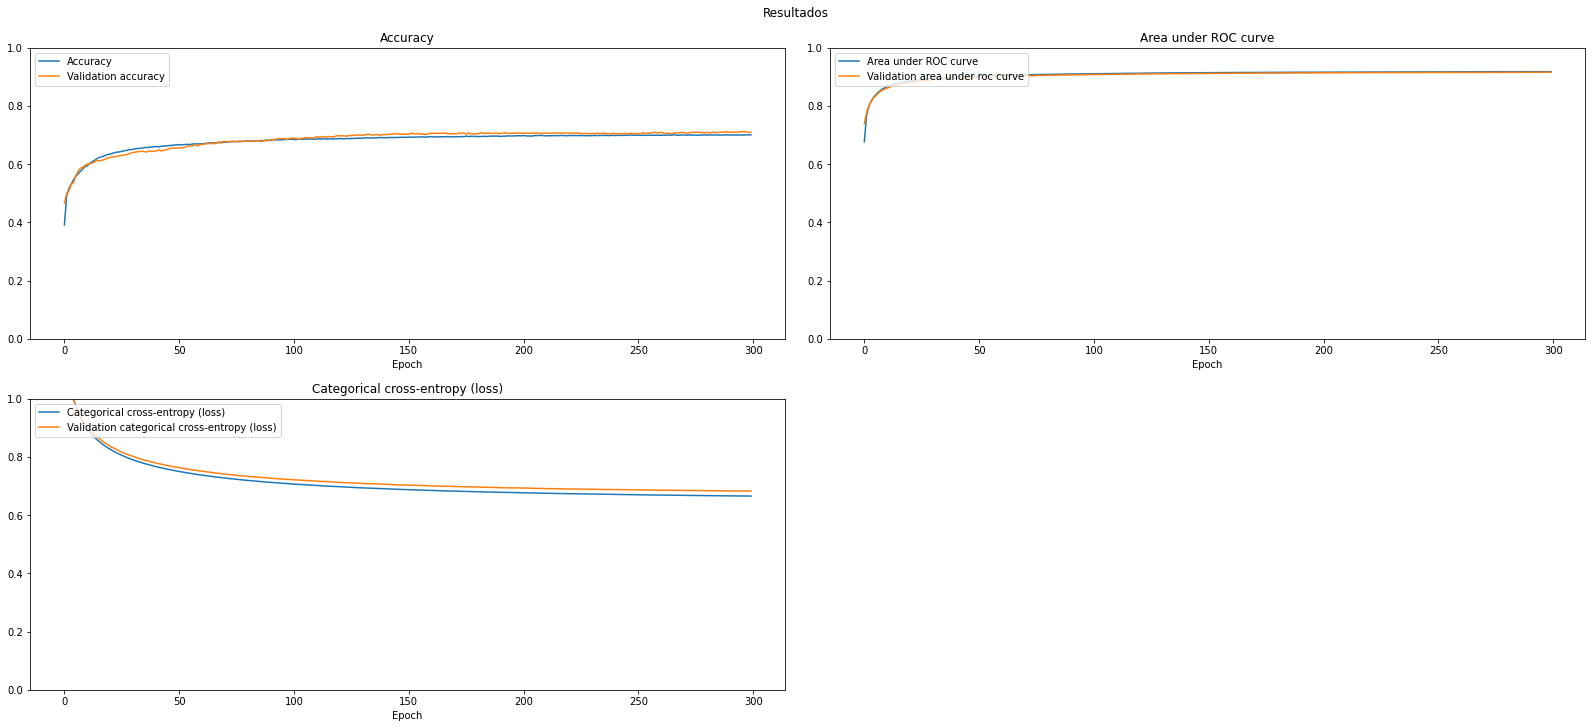

In [5]:
nn = krm.Sequential()
exp = Experiment(e_id='bias_decrease_1_1', model=nn, epochs=300, verbose=1)
exp.run()

### Intento 1.2 de reducir el bias

Primero intentaremos aumentar la complejidad de la red para ver si conseguimos disminuir el bias de la red. En esta iteración se probara con una red con 2 capas ocultas con 12 y 8 neuronas.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12)                216       
                                                                 
 dense_2 (Dense)             (None, 8)                 104       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
Total params: 356
Trainable params: 356
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /gdrive/MyDrive/RedesNeuronales/models/bias_decrease_1_2/tfmodel/assets
51/51 [==============================] - 0s 2ms/step - loss: 0.5370 - categorical_accuracy: 0.7612 - auc: 0.9471
Human error: 0.00%
Bias=(1-train_accuracy) - human error: 23.34%
Variance=(1-val_accuracy) - bias: 0

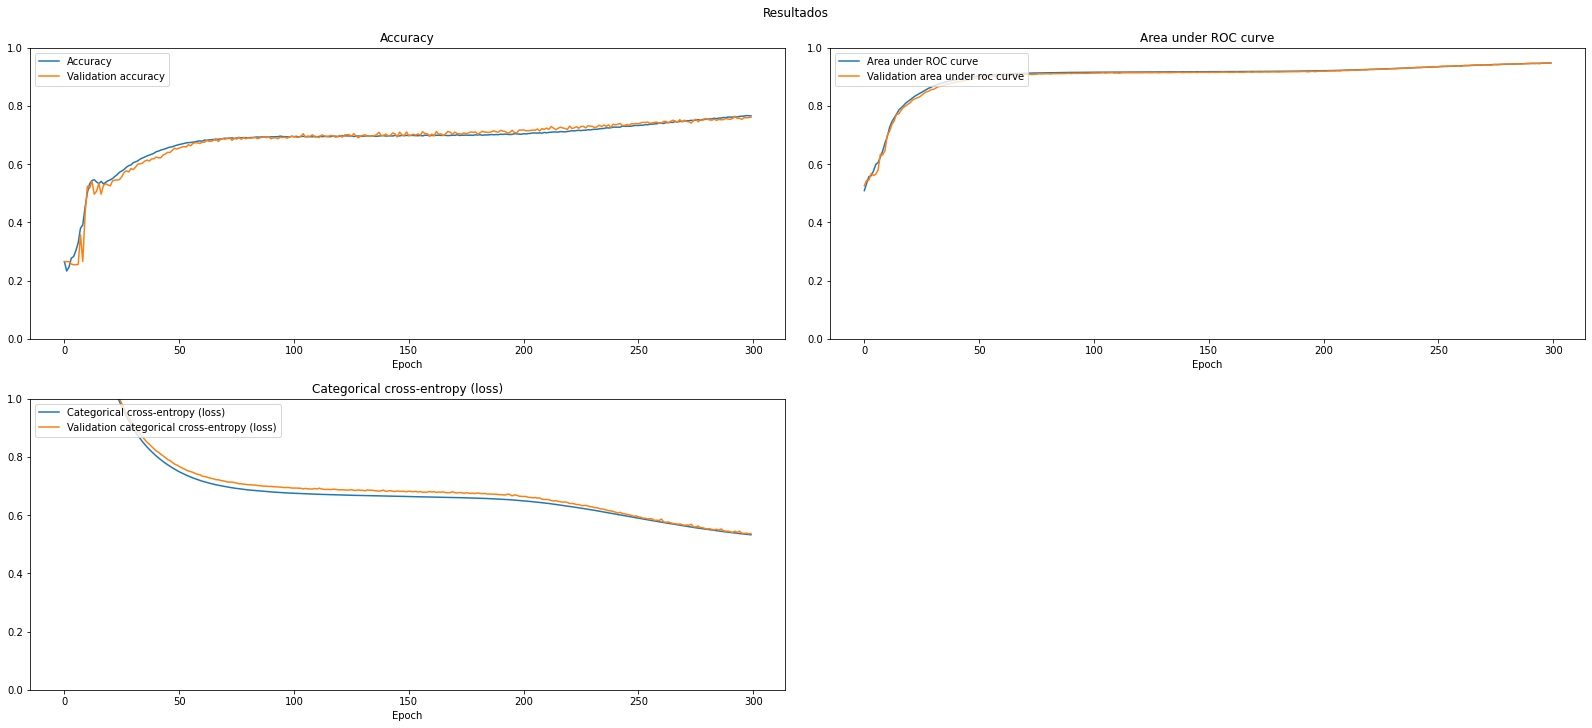

In [6]:
nn = krm.Sequential()
nn.add(krl.Dense(units=OUTPUTS*3, activation='sigmoid'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='sigmoid'))
exp = Experiment(e_id='bias_decrease_1_2', model=nn, epochs=300, verbose=1)
exp.run()

### Intento 1.3 de reducir el bias

Con la iteración anterior conseguimos reducir el bias, sin embargo en esta iteración proponemos el uso de un optimizador mejor con la esperanza de reducir aún más el bias.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12)                216       
                                                                 
 dense_5 (Dense)             (None, 8)                 104       
                                                                 
 dense_6 (Dense)             (None, 4)                 36        
                                                                 
Total params: 356
Trainable params: 356
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /gdrive/MyDrive/RedesNeuronales/models/bias_decrease_1_3/tfmodel/assets
51/51 [==============================] - 0s 2ms/step - loss: 0.4540 - categorical_accuracy: 0.7841 - auc: 0.9602
Human error: 0.00%
Bias=(1-train_accuracy) - human error: 18.70%
Variance=(1-val_accuracy) - bias: 2

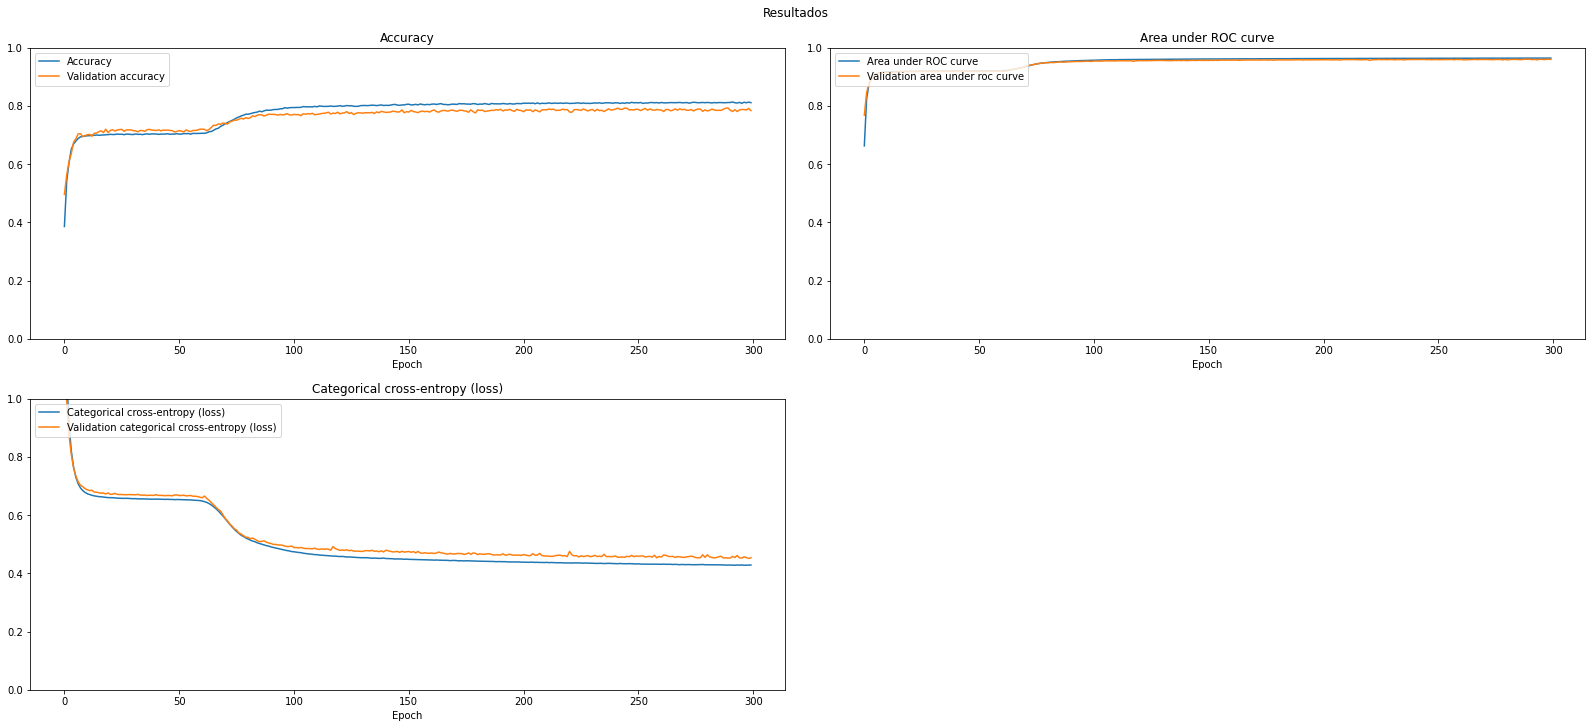

In [7]:
nn = krm.Sequential()
nn.add(krl.Dense(units=OUTPUTS*3, activation='sigmoid'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='sigmoid'))

exp = Experiment(
    e_id='bias_decrease_1_3', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.4 de reducir el bias

Gracias al uso del optimizador Adam hemos conseguido reducir el bias. A continuación intenteramos aumentar las capas de la red para ver si se puede obtener un mejor rendimiento.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 16)                288       
                                                                 
 dense_20 (Dense)            (None, 12)                204       
                                                                 
 dense_21 (Dense)            (None, 8)                 104       
                                                                 
 dense_22 (Dense)            (None, 4)                 36        
                                                                 
Total params: 632
Trainable params: 632
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /gdrive/MyDrive/RedesNeuronales/models/bias_decrease_1_4/tfmodel/assets
51/51 [==============================] - 0s 2ms/step - loss: 0.4415 - categorical

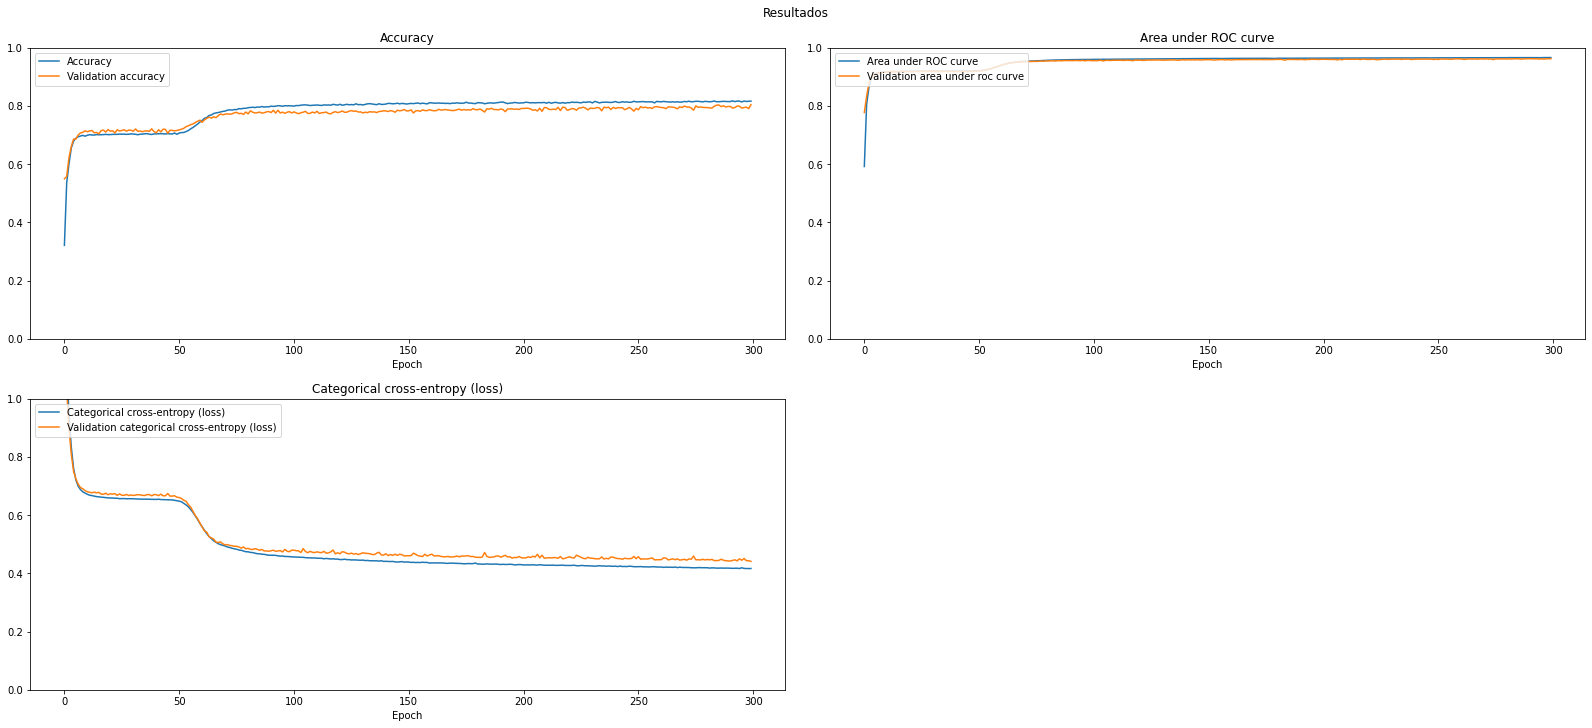

In [11]:
nn = krm.Sequential()
nn.add(krl.Dense(units=OUTPUTS*4, activation='sigmoid'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='sigmoid'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='sigmoid'))

exp = Experiment(
    e_id='bias_decrease_1_4', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.5 de reducir el bias

Tras aumentar el número de capas de la red hemos conseguido una mejora, por lo que ahora proponemos cambiar las funciones de activación para poder reducir aún más el bias.

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 16)                288       
                                                                 
 dense_40 (Dense)            (None, 12)                204       
                                                                 
 dense_41 (Dense)            (None, 8)                 104       
                                                                 
 dense_42 (Dense)            (None, 4)                 36        
                                                                 
Total params: 632
Trainable params: 632
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /gdrive/MyDrive/RedesNeuronales/models/bias_decrease_1_5/tfmodel/assets
51/51 [==============================] - 0s 2ms/step - loss: 0.4353 - categorica

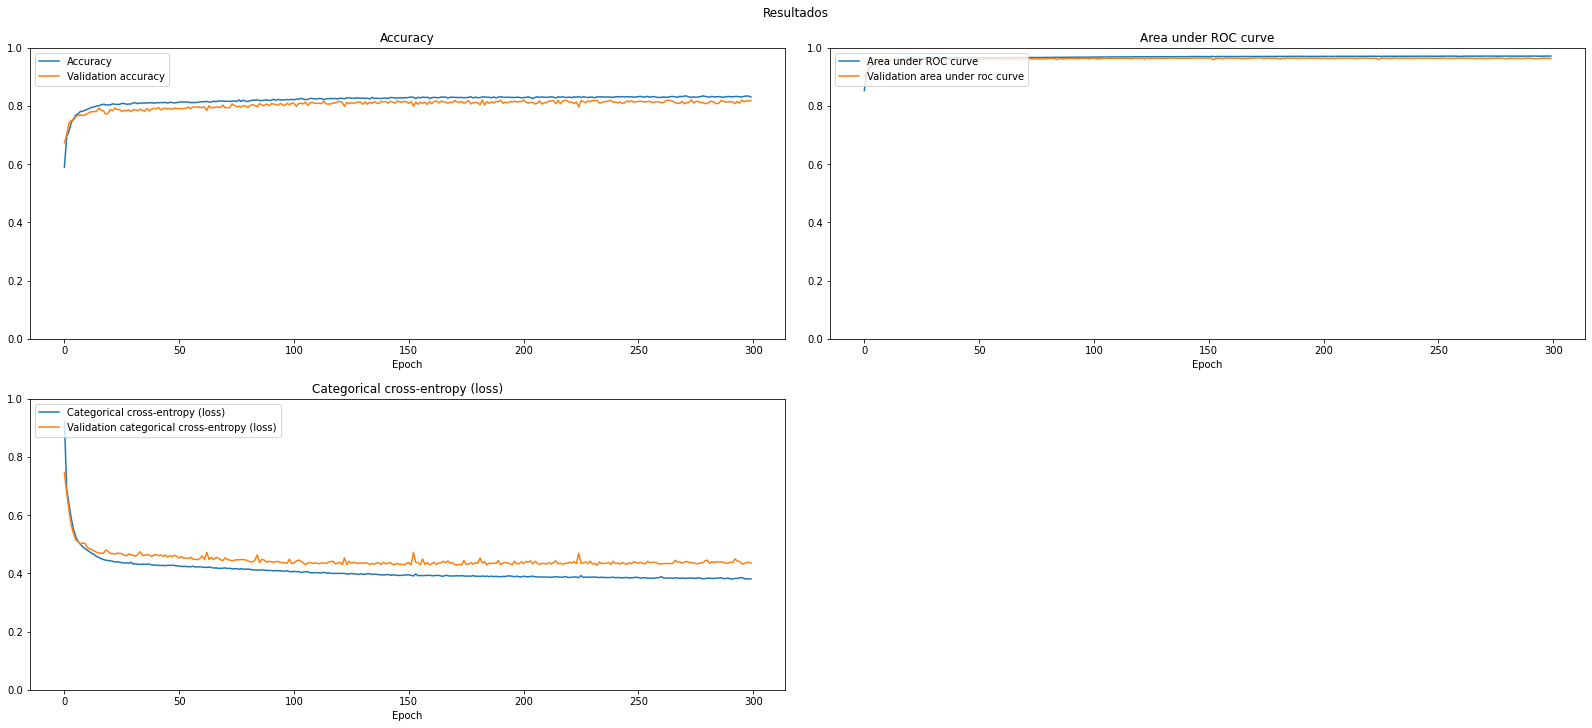

In [16]:
nn = krm.Sequential()
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='bias_decrease_1_5', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.6 de reducir el bias

En la anterior iteración conseguimos reducir bastente el bias, sin embargo aumentamos un poco la varianza. Antes de comenzar reducir la varianza, trataremos de reducir más el bias añadiendo más capas y neuronas a la red.

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 20)                360       
                                                                 
 dense_44 (Dense)            (None, 16)                336       
                                                                 
 dense_45 (Dense)            (None, 12)                204       
                                                                 
 dense_46 (Dense)            (None, 8)                 104       
                                                                 
 dense_47 (Dense)            (None, 4)                 36        
                                                                 
Total params: 1,040
Trainable params: 1,040
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: /gdrive/MyDrive/

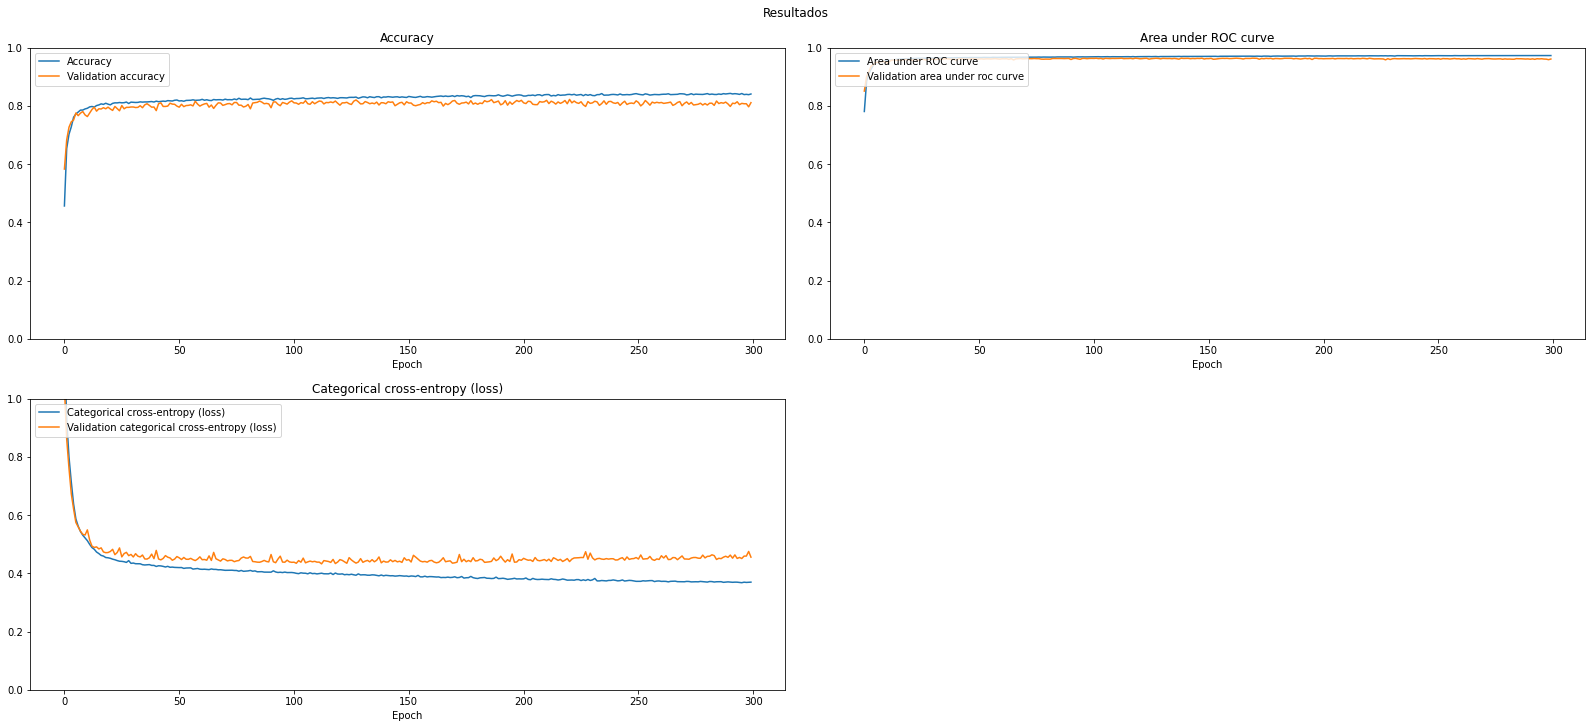

In [17]:
nn = krm.Sequential()

nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='bias_decrease_1_6', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.7 de reducir el bias

Parece que se consigue reducir mucho el bias con añadiendole más capas con más neuronas y la función de activación tanh, por lo que intentaremos repetir este procedimiento durante las siguientes iteraciones

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 24)                432       
                                                                 
 dense_49 (Dense)            (None, 20)                500       
                                                                 
 dense_50 (Dense)            (None, 16)                336       
                                                                 
 dense_51 (Dense)            (None, 12)                204       
                                                                 
 dense_52 (Dense)            (None, 8)                 104       
                                                                 
 dense_53 (Dense)            (None, 4)                 36        
                                                                 
Total params: 1,612
Trainable params: 1,612
Non-train

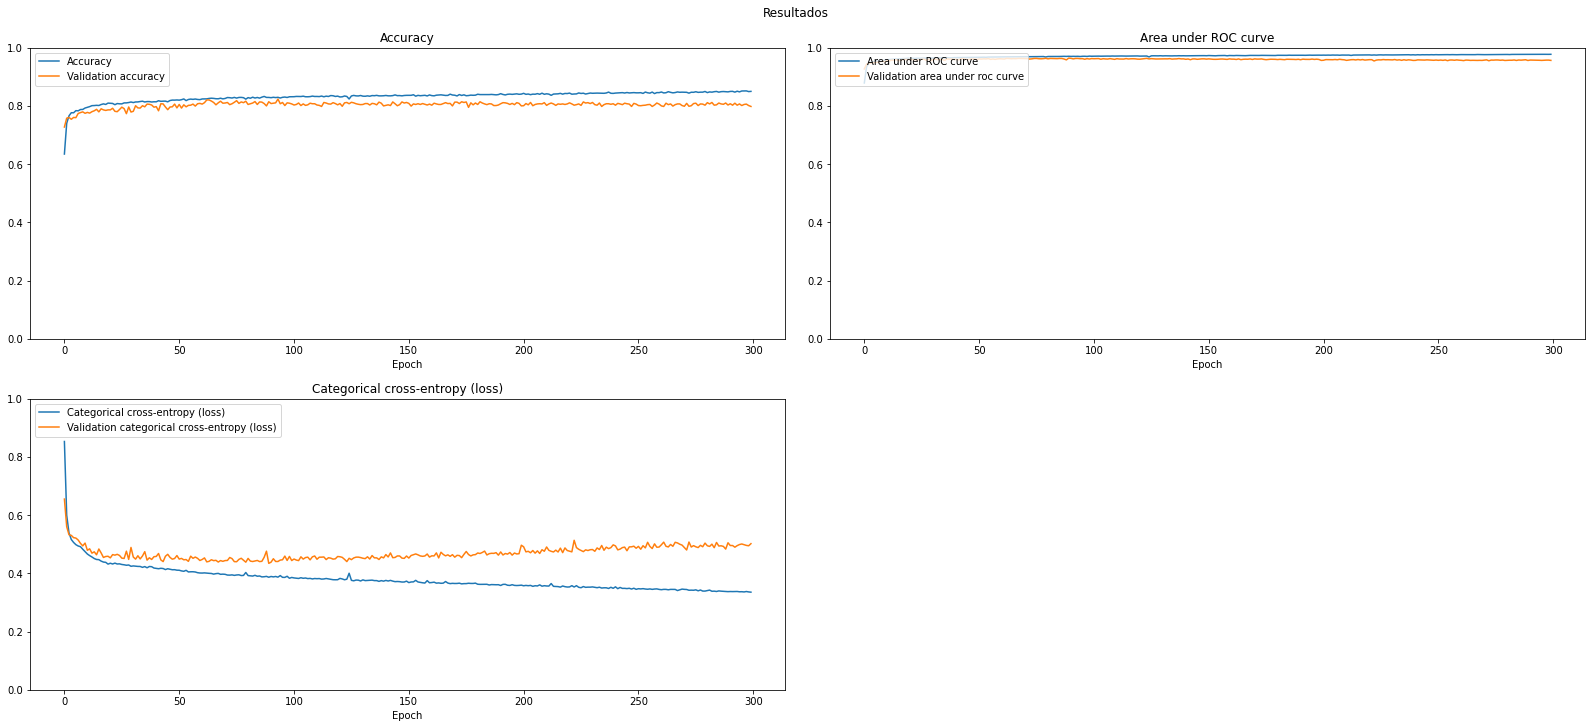

In [18]:
nn = krm.Sequential()

nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='bias_decrease_1_7', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.8 de reducir el bias

Parece que se consigue reducir mucho el bias con añadiendole más capas con más neuronas y la función de activación tanh, por lo que intentaremos repetir este procedimiento durante las siguientes épocas

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 28)                504       
                                                                 
 dense_29 (Dense)            (None, 24)                696       
                                                                 
 dense_30 (Dense)            (None, 20)                500       
                                                                 
 dense_31 (Dense)            (None, 16)                336       
                                                                 
 dense_32 (Dense)            (None, 12)                204       
                                                                 
 dense_33 (Dense)            (None, 8)                 104       
                                                                 
 dense_34 (Dense)            (None, 4)                

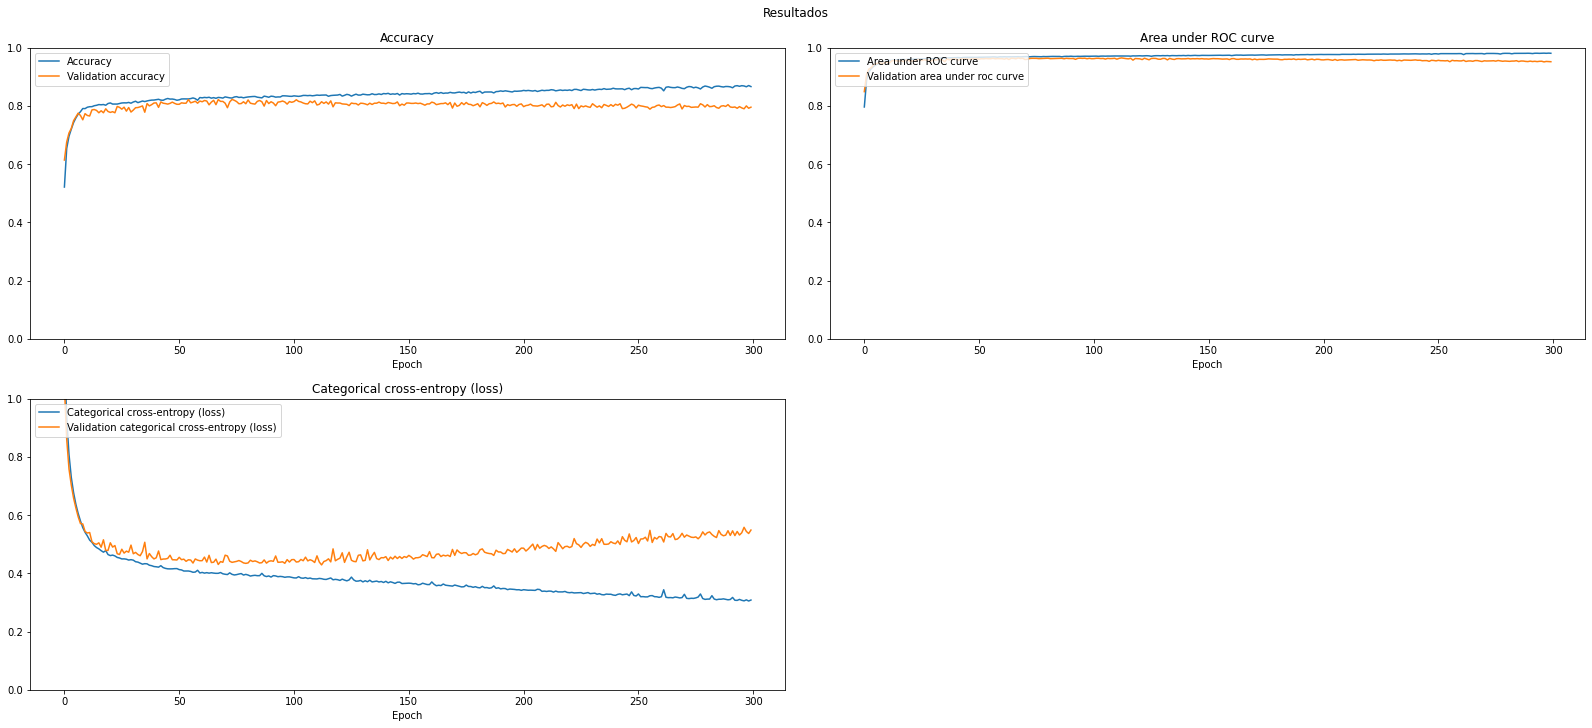

In [ ]:
nn = krm.Sequential()


nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='bias_decrease_1_8', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.9 de reducir el bias

Parece que se consigue reducir mucho el bias con añadiendole más capas con más neuronas y la función de activación tanh, por lo que intentaremos repetir este procedimiento durante las siguientes épocas

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 32)                576       
                                                                 
 dense_61 (Dense)            (None, 28)                924       
                                                                 
 dense_62 (Dense)            (None, 24)                696       
                                                                 
 dense_63 (Dense)            (None, 20)                500       
                                                                 
 dense_64 (Dense)            (None, 16)                336       
                                                                 
 dense_65 (Dense)            (None, 12)                204       
                                                                 
 dense_66 (Dense)            (None, 8)               

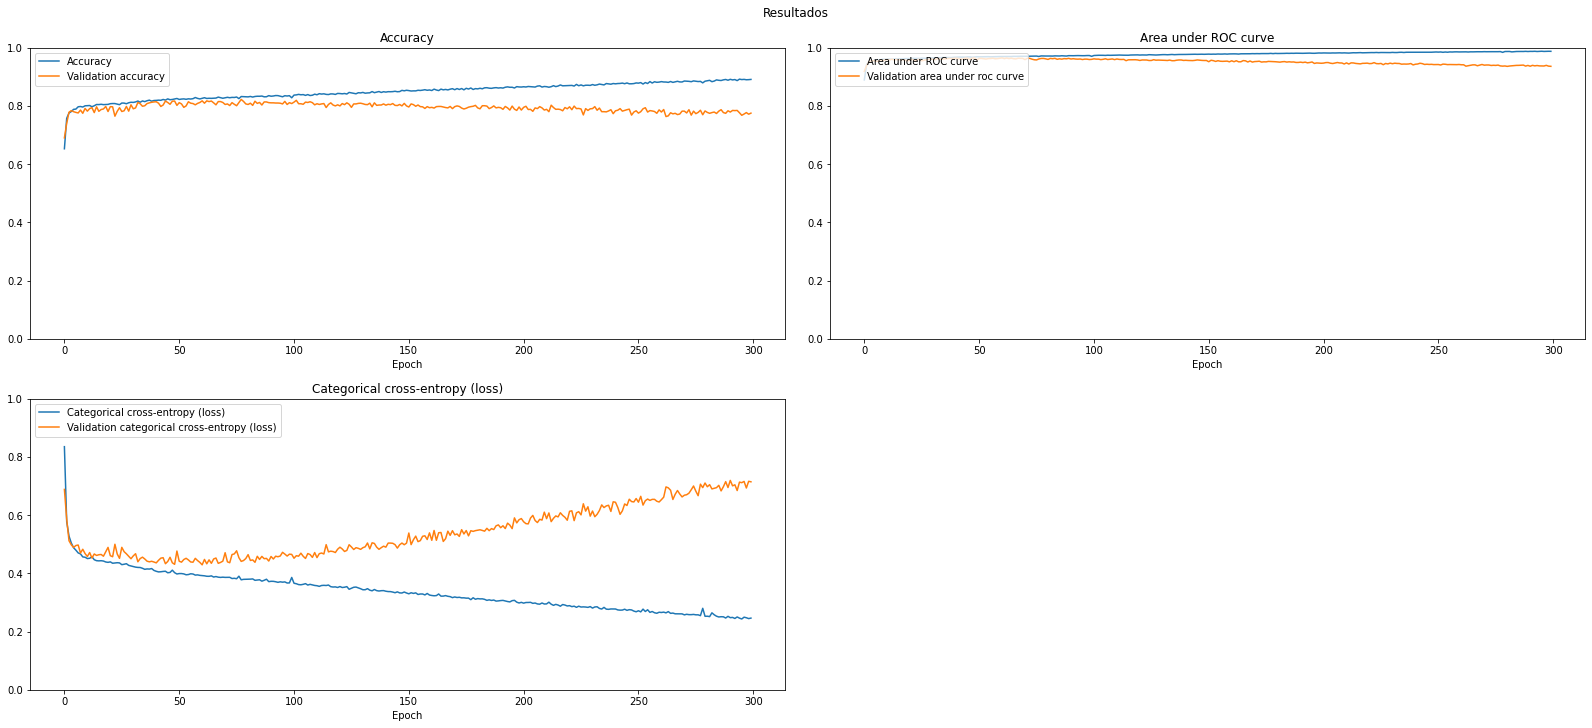

In [20]:
nn = krm.Sequential()

nn.add(krl.Dense(units=OUTPUTS*8, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='bias_decrease_1_9', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.10 de reducir el bias

Parece que se consigue reducir mucho el bias con añadiendole más capas con más neuronas y la función de activación tanh, por lo que intentaremos repetir este procedimiento durante las siguientes épocas.

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 40)                720       
                                                                 
 dense_69 (Dense)            (None, 36)                1476      
                                                                 
 dense_70 (Dense)            (None, 32)                1184      
                                                                 
 dense_71 (Dense)            (None, 28)                924       
                                                                 
 dense_72 (Dense)            (None, 24)                696       
                                                                 
 dense_73 (Dense)            (None, 20)                500       
                                                                 
 dense_74 (Dense)            (None, 16)              

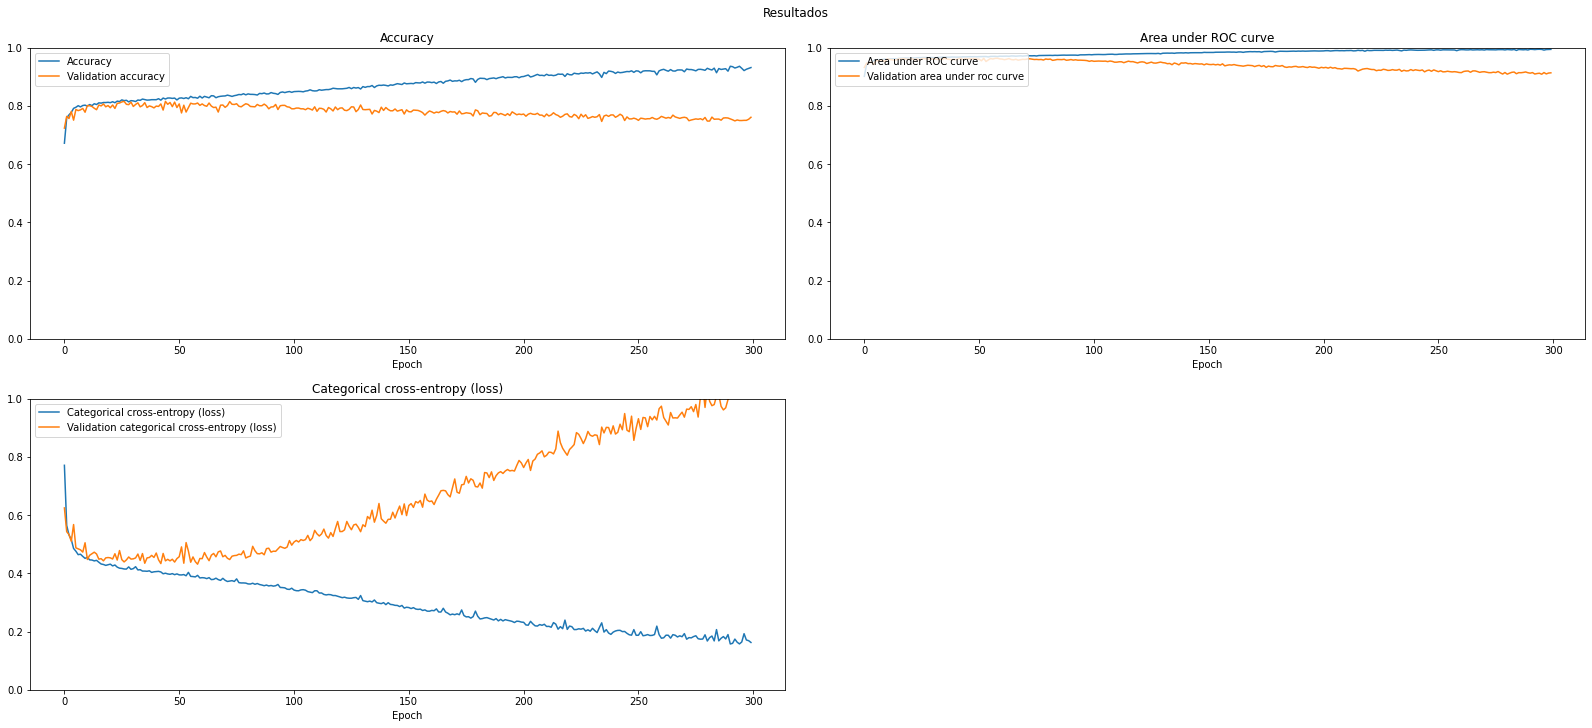

In [21]:
nn = krm.Sequential()

nn.add(krl.Dense(units=OUTPUTS*10, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*9, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*8, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='bias_decrease_1_10', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.11 de reducir el bias

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 48)                864       
                                                                 
 dense_79 (Dense)            (None, 44)                2156      
                                                                 
 dense_80 (Dense)            (None, 40)                1800      
                                                                 
 dense_81 (Dense)            (None, 36)                1476      
                                                                 
 dense_82 (Dense)            (None, 32)                1184      
                                                                 
 dense_83 (Dense)            (None, 28)                924       
                                                                 
 dense_84 (Dense)            (None, 24)              

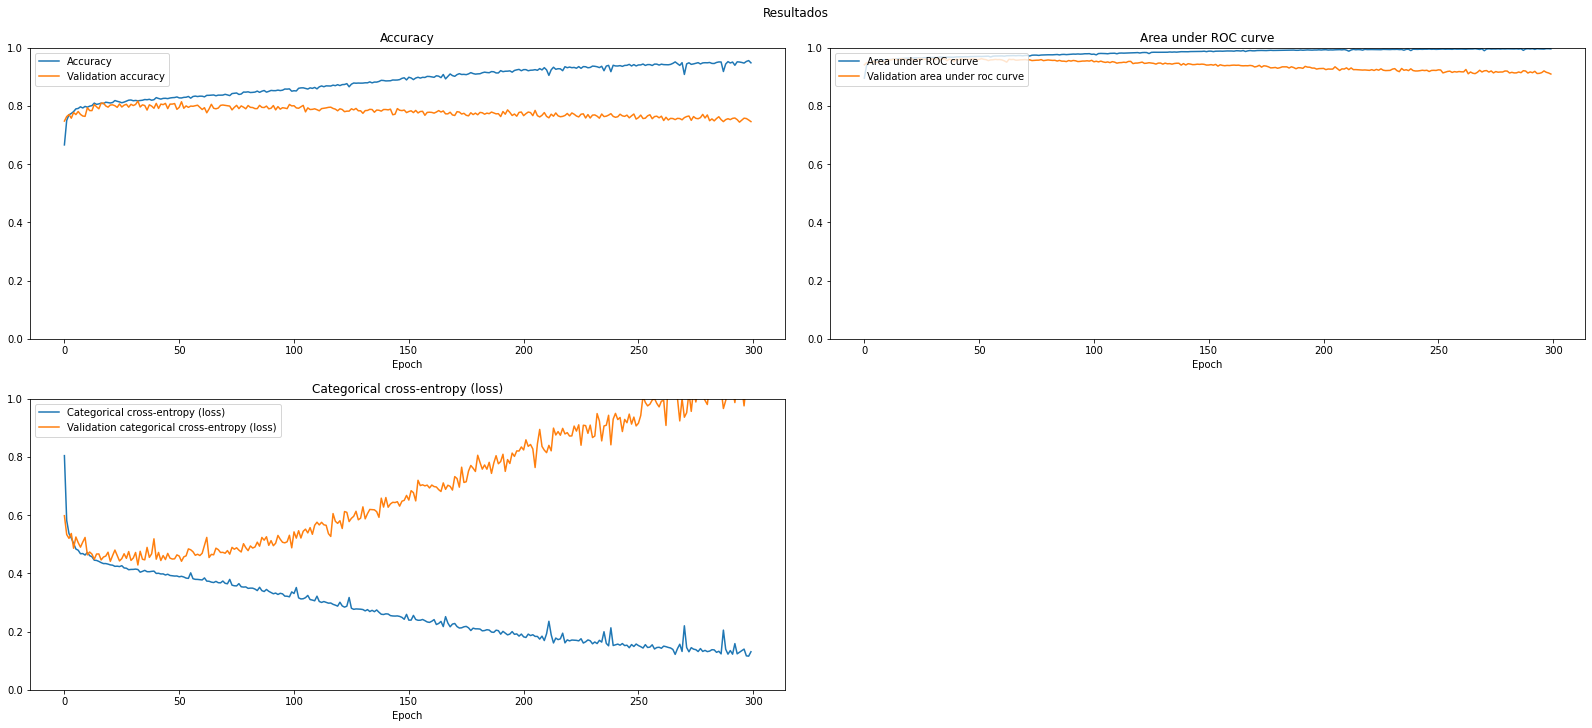

In [22]:
nn = krm.Sequential()

nn.add(krl.Dense(units=OUTPUTS*12, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*11, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*10, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*9, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*8, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='bias_decrease_1_11', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.12 de reducir el bias

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 56)                1008      
                                                                 
 dense_91 (Dense)            (None, 52)                2964      
                                                                 
 dense_92 (Dense)            (None, 48)                2544      
                                                                 
 dense_93 (Dense)            (None, 44)                2156      
                                                                 
 dense_94 (Dense)            (None, 40)                1800      
                                                                 
 dense_95 (Dense)            (None, 36)                1476      
                                                                 
 dense_96 (Dense)            (None, 32)              

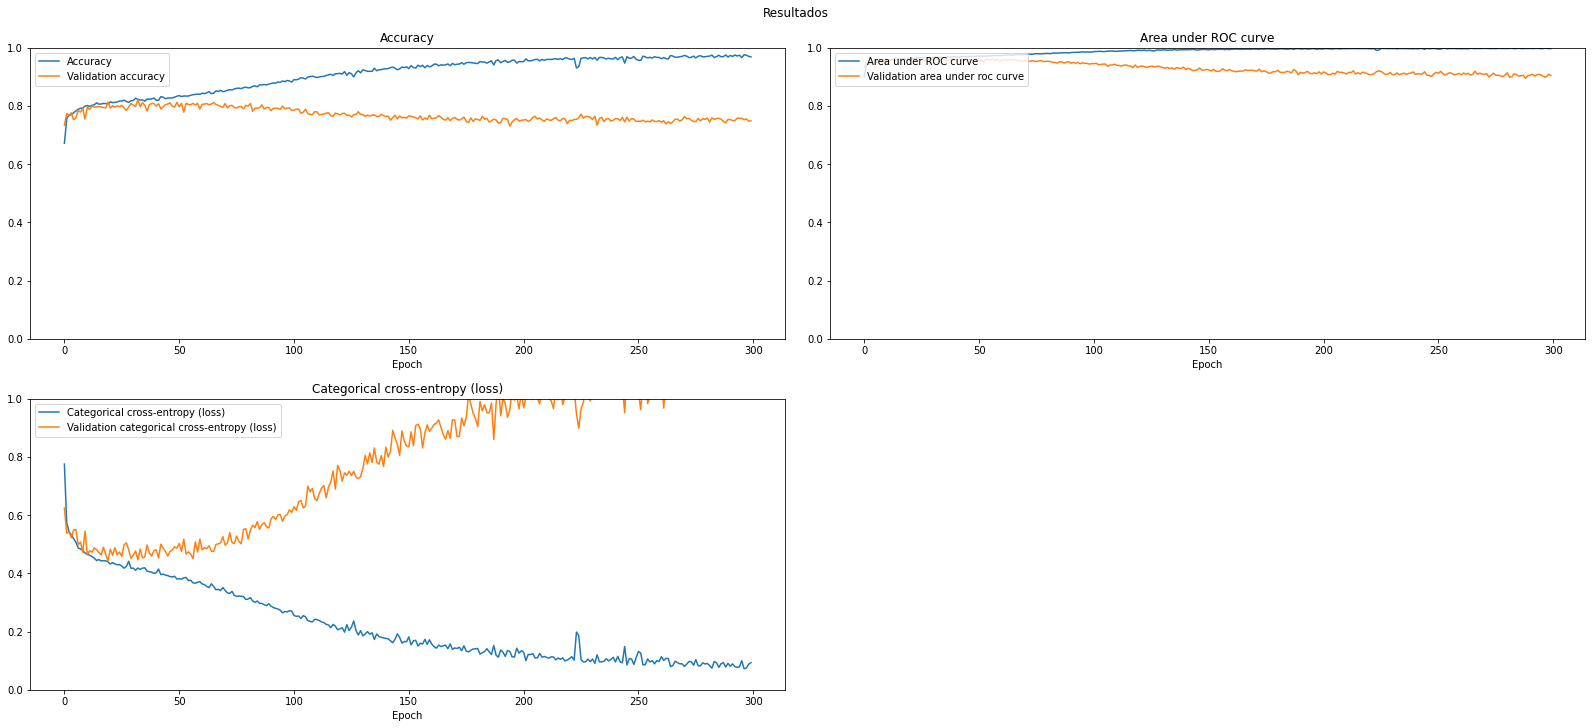

In [23]:
nn = krm.Sequential()


nn.add(krl.Dense(units=OUTPUTS*14, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*13, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*12, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*11, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*10, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*9, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*8, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='bias_decrease_1_12', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.1_error_1 de reducir la varianza
Como hemos visto en el ejemplo anterior, el bias se ha reducido ya a un valor bastante aceptable; sin embargo, la varianza a aumentado demasiado, indicando que tenemos un claro ejemplo de overfiting, por lo que intentaremos centrarnos en reducirla. Para ello, comenzaremos aplicando regularizadores en las capas.

Añadir regularizadores a todas las capas ha resultado en un error.

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 56)                1008      
                                                                 
 dense_91 (Dense)            (None, 52)                2964      
                                                                 
 dense_92 (Dense)            (None, 48)                2544      
                                                                 
 dense_93 (Dense)            (None, 44)                2156      
                                                                 
 dense_94 (Dense)            (None, 40)                1800      
                                                                 
 dense_95 (Dense)            (None, 36)                1476      
                                                                 
 dense_96 (Dense)            (None, 32)              

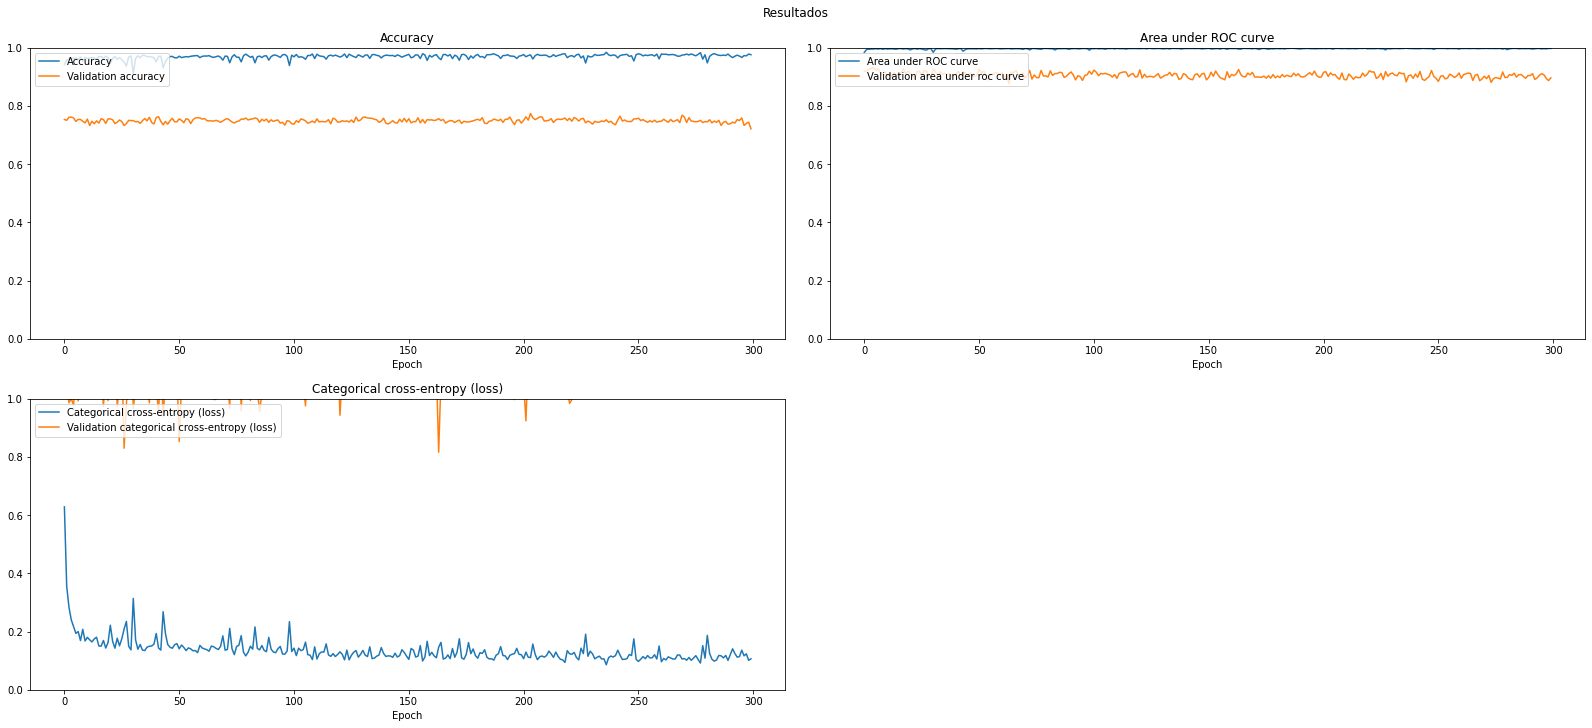

In [24]:
nn.add(krl.Dense(units=OUTPUTS*14, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*13, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*12, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*11, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*10, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*9, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*8, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))

exp = Experiment(
    e_id='variance_decrease_1_1_error_1', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.1_error_2 de reducir la varianza

En el caso anterior intentamos añadir regularizadores a todas las capas, lo que resultó en un error, en este caso intentaremos añadir regularizadores solo a 5 capas.

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 56)                1008      
                                                                 
 dense_91 (Dense)            (None, 52)                2964      
                                                                 
 dense_92 (Dense)            (None, 48)                2544      
                                                                 
 dense_93 (Dense)            (None, 44)                2156      
                                                                 
 dense_94 (Dense)            (None, 40)                1800      
                                                                 
 dense_95 (Dense)            (None, 36)                1476      
                                                                 
 dense_96 (Dense)            (None, 32)              

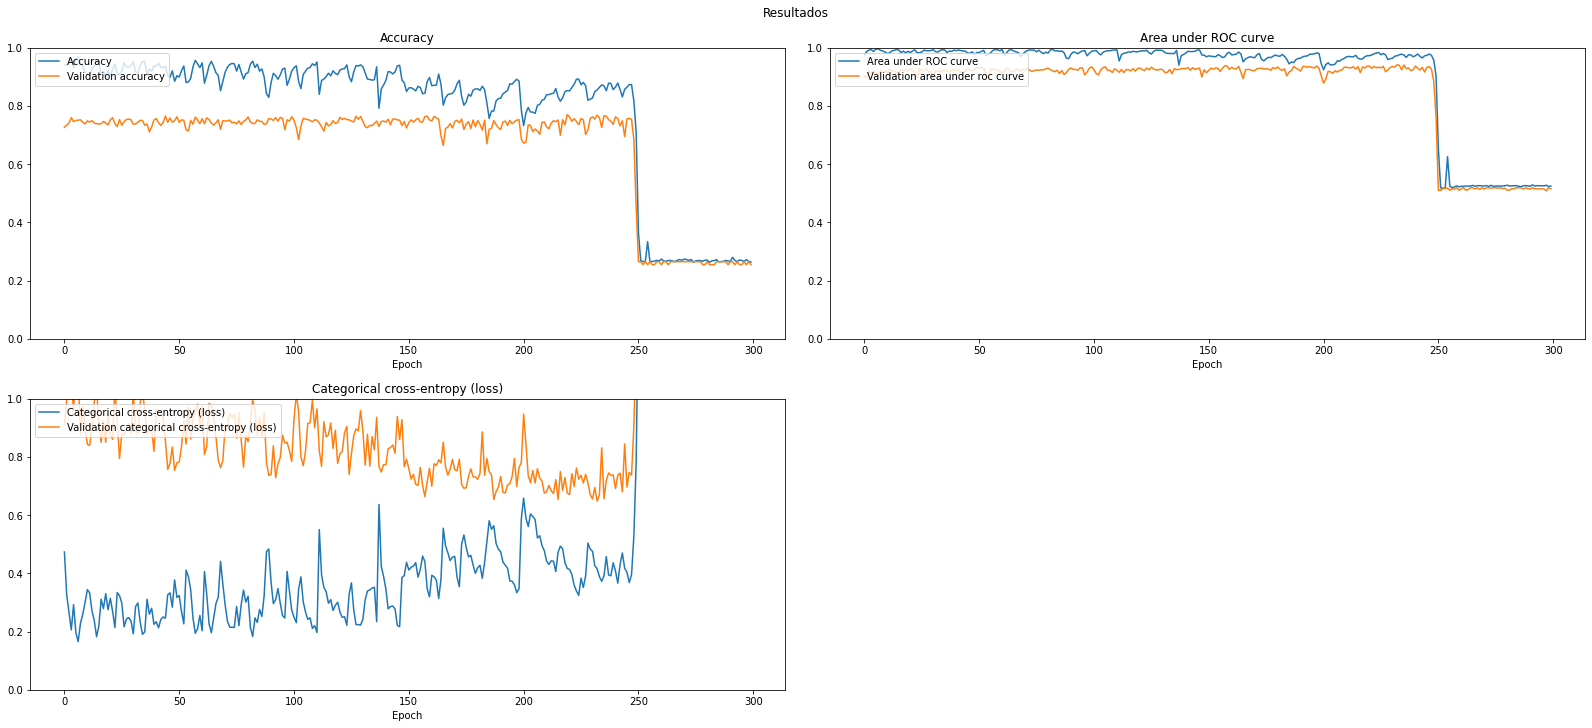

In [25]:
nn.add(krl.Dense(units=OUTPUTS*14, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*13, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*12, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*11, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*10, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*9, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*8, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))

exp = Experiment(
    e_id='variance_decrease_1_1_error_2', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 1.1_error_2 de reducir la varianza

En el caso anterior intentamos añadir regularizadores a las capas finales, lo que dio un resultado bastante malo, en esta ocasión intentaremos añadir los reguladores a las capas iniciales de la red

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_133 (Dense)           (None, 56)                1008      
                                                                 
 dense_134 (Dense)           (None, 52)                2964      
                                                                 
 dense_135 (Dense)           (None, 48)                2544      
                                                                 
 dense_136 (Dense)           (None, 44)                2156      
                                                                 
 dense_137 (Dense)           (None, 40)                1800      
                                                                 
 dense_138 (Dense)           (None, 36)                1476      
                                                                 
 dense_139 (Dense)           (None, 32)              

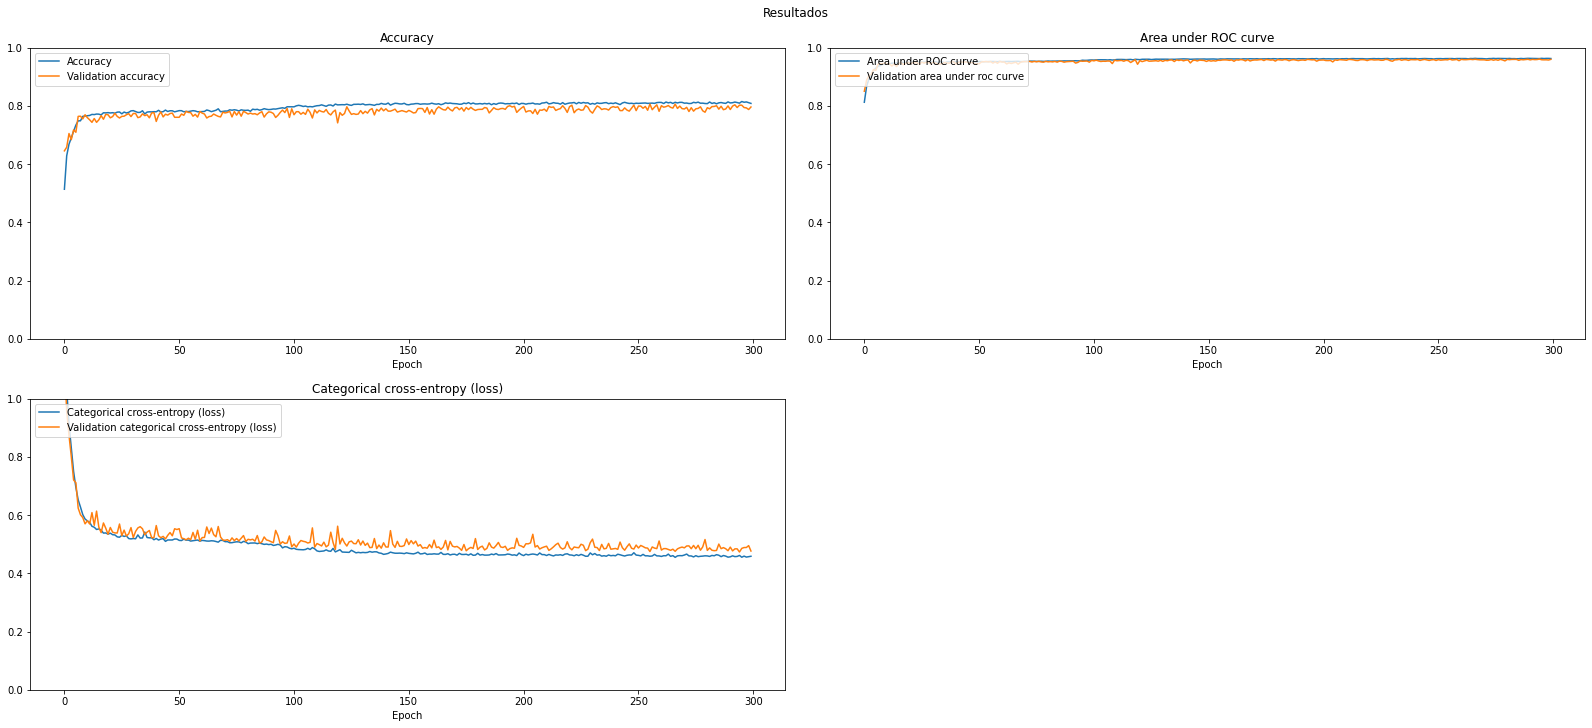

In [ ]:
nn = krm.Sequential()


nn.add(krl.Dense(units=OUTPUTS*14, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*13, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*12, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*11, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*10, activation='tanh', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*9, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*8, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*7, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*6, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*5, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='tanh'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='tanh'))

exp = Experiment(
    e_id='variance_decrease_1_1', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()

### Intento 2.1 de reducir el bias

Tras el anterior prueba conseguimos reducir la varianza bastante mediante el uso de reguladores, en esta ocasión intentaremos volver a reducir el bias, con la función de activación relu.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 56)                1008      
                                                                 
 dense_1 (Dense)             (None, 52)                2964      
                                                                 
 dense_2 (Dense)             (None, 48)                2544      
                                                                 
 dense_3 (Dense)             (None, 44)                2156      
                                                                 
 dense_4 (Dense)             (None, 40)                1800      
                                                                 
 dense_5 (Dense)             (None, 36)                1476      
                                                                 
 dense_6 (Dense)             (None, 32)                1

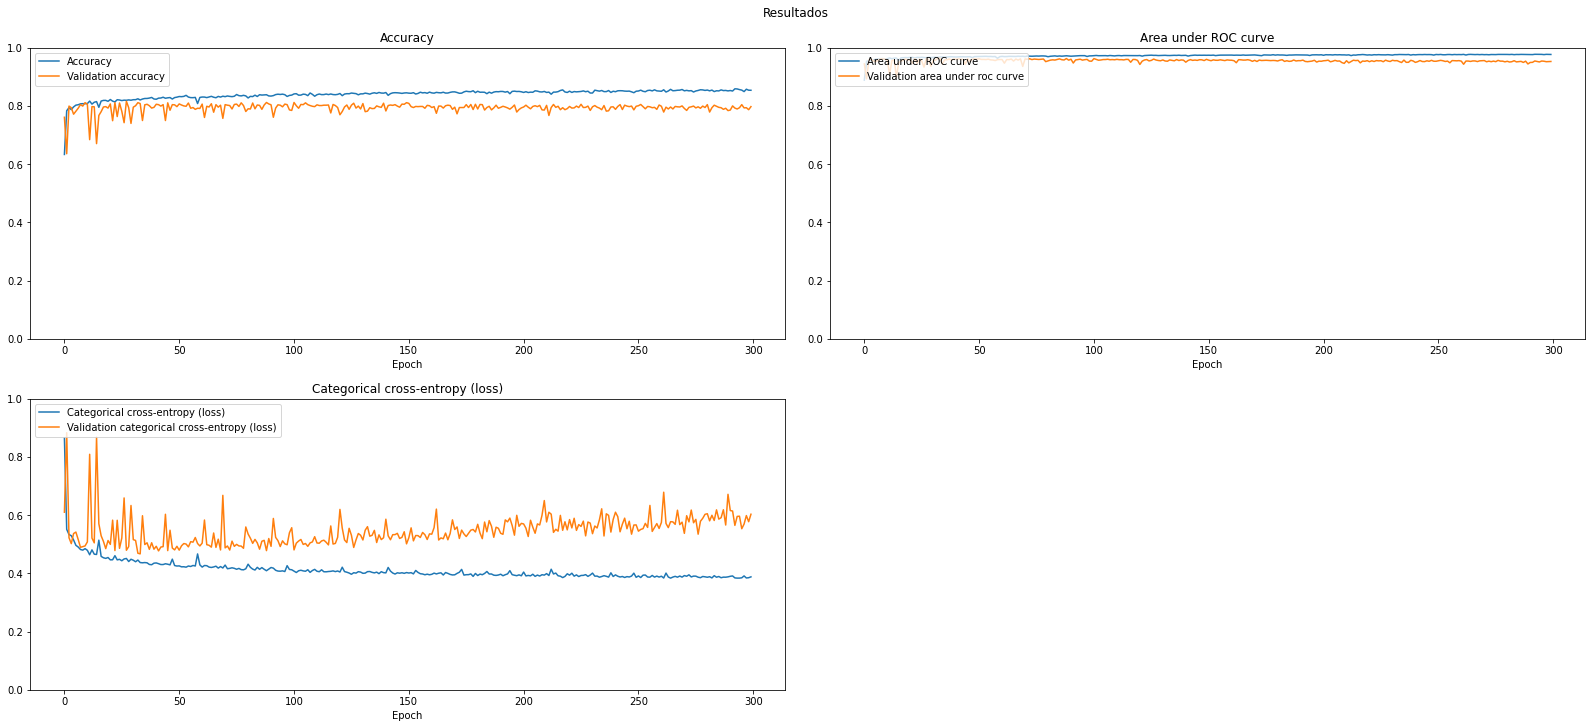

In [5]:
nn = krm.Sequential()


nn.add(krl.Dense(units=OUTPUTS*14, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*13, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*12, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*11, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*10, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
nn.add(krl.Dense(units=OUTPUTS*9, activation='relu'))
nn.add(krl.Dense(units=OUTPUTS*8, activation='relu'))
nn.add(krl.Dense(units=OUTPUTS*7, activation='relu'))
nn.add(krl.Dense(units=OUTPUTS*6, activation='relu'))
nn.add(krl.Dense(units=OUTPUTS*5, activation='relu'))
nn.add(krl.Dense(units=OUTPUTS*4, activation='relu'))
nn.add(krl.Dense(units=OUTPUTS*3, activation='relu'))
nn.add(krl.Dense(units=OUTPUTS*2, activation='relu'))

exp = Experiment(
    e_id='bias_decrease_2_1', 
    model=nn, optimizer='Adam',
    epochs=300,
    verbose=1
    )

exp.run()